In [2]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
import cv2
import pandas as pd
import random

In [3]:
#Function to generate a dimxdim image of a random shape of a size between given bounds
def shape_gen(dim, minimum,maximum):
    x = random_shapes((dim, dim), max_shapes=1, multichannel=False, intensity_range=(0,0),min_size = minimum, max_size=maximum)[0]
    x = -1*x+255
    return(x)

In [4]:
#Create array of start images
images_seq = [shape_gen(32,10,25) for i in range(1000)]
images_seq = np.array(images_seq)
images_seq = np.expand_dims(images_seq,1)
images_seq.shape

(1000, 1, 32, 32)

In [5]:
#For a given collection of start images with (n,1,k,k), with n images of dimension k by k. Trans_range is one-sided,
#so trans_range = 4 allows translations of 4 up or down, 4 left or right. same for rot_center, how much the center of 
#rotation can shift to one-side both up/down. rot_angle is maximum angle in DEGREES
def rand_trans(data, trans_range, rot_center, rot_angle): 
    n, row, col = data[:,0,:,:].shape
    Index = [random.randint(0,1) for i in range(n)] #randomly choose either translation or rotation
    
    def M_gen(i):
        if i == 0:
            hor = random.randint(-trans_range, trans_range)
            ver = random.randint(-trans_range, trans_range)
            x = np.float32([[1,0,hor],[0,1,ver]]) #create translation matrix
        else:
            center = (row/2+random.randint(-rot_center,rot_center),col/2+random.randint(-rot_center,rot_center))
            angle = random.uniform(0,rot_angle)
            x = cv2.getRotationMatrix2D(center,angle,1) #create rotation matrix
        return(x)
    
    Z = np.array([M_gen(i) for i in Index])
    
    return(Z)
    

In [6]:
M = rand_trans(images_seq, 3, 3, 45)
M.shape

(1000, 2, 3)

In [7]:
#for a given collection of start images - "data" - and their associated transformations -"transform", one for each start image-
#will generate a movie sequence of the desired length. note "data" should be np.array of shape (n,1,k,k).
def image_gen(data, transform, movie_len):
    X = data
    for j in range(movie_len-1):
        Y = np.array([cv2.warpAffine(X[i,j],M[i],(32,32)) for i in range(data.shape[0])])
        Y = np.expand_dims(Y,1) #add the second axis, which denotes time, to concatenate the images
        X = np.concatenate((X,Y),axis=1)
    
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2]**2)
    return(X) #reshape so it's easier to work with

In [8]:
new = image_gen(images_seq, M, 10)

In [9]:
M[17]

array([[ 0.99293581,  0.11865275, -2.02978673],
       [-0.11865275,  0.99293581,  1.90694671]])

In [101]:
new2 = new.reshape(new.shape[0],new.shape[1], 32, 32)[:10,:,:,:]

In [129]:
new[:10].shape

(10, 10, 1024)

In [126]:
newmax = np.abs(new2).max(axis=(2,3), keepdims= True)

In [127]:
newmax.shape

(10, 10, 1, 1)

In [128]:
new2/newmax

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0. 

In [1]:
def normal_matrix(dim, center, radius, epsilon):
    normal_matrix = np.empty((dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
   
    for i in range(dim):
        for j in range(dim):
            normal_matrix[i,j] = np.linalg.norm(np.array([i,j])-center)/radius
    normal_matrix[normal_matrix <= 1+ epsilon] = 1
    normal_matrix[normal_matrix > 1 + epsilon] = 0
    
    return(normal_matrix)

In [16]:
def localImage(Input2, movie_length, dim, center, radius, epsilon):
    local_matrix = np.empty((center.shape[1], time, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.shape[2]):
        for t in range(time):
            for i in range(dim):
                for j in range(dim):
                    local_matrix[k,t,i,j] = np.abs(np.dot(np.array([i,j])-center[:,t,k]))/radius[t,k]
    local_matrix[local_matrix <= 1+ epsilon] = 1
    local_matrix[local_matrix < 1 + epsilon] = 0
    
    LocalInput2 = np.multiply(local_matrix, LocalInput2)
    
    return(LocalInput2)

In [ ]:
movie_length = 3
time

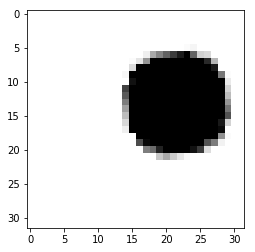

In [14]:
plt.imshow(np.multiply(normal_matrix(32, [16,16], 17, .001), new[17,1].reshape((32,32))), cmap = "Greys")

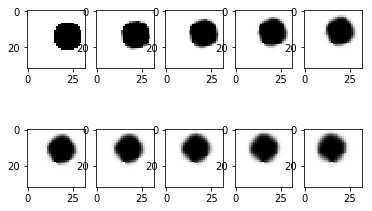

In [10]:
#Showing that un-doing the reshape preserves geometric ordering of image:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(new[17,i].reshape((32,32)),cmap = "Greys")

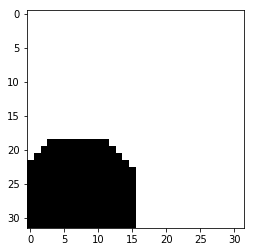

In [29]:
#Translation matrix
col, row = 32, 32

test = new[0,0]

M = np.float32([[1,0,-10],[0,1,5]])
dst = cv2.warpAffine(test,M,(col,row))

plt.imshow(dst,cmap='Greys')

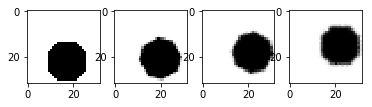

In [28]:
#Rotation matrix

N = cv2.getRotationMatrix2D((col/2,row/2),30,1) #center, angle, scaling
dst2 = cv2.warpAffine(test,N,(col,row))
dst3 = cv2.warpAffine(dst2,N,(col,row))
dst4 = cv2.warpAffine(dst3,N,(col,row))

c = [test,dst2,dst3,dst4]

for i in range(4):
    plt.subplot(1,4, i+1)
    plt.imshow(c[i],cmap = "Greys")